In [1]:
import matplotlib.pyplot as plt
import math

In [2]:
# why ensemble learning works better
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [math.comb(n_classifier, k) * error ** k * (1 - error)**(n_classifier - k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)
print(ensemble_error(11, 0.25))

0.03432750701904297


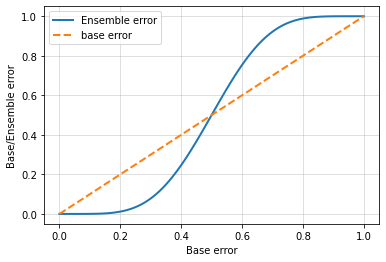

In [3]:
import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(11, error) for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [4]:
# using MajorityVoting to make predictions
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [5]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

In [8]:
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %.2f(+/- %0.2f) [%s]" % (scores.
                                             mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92(+/- 0.15) [Logistic Regression]
ROC AUC: 0.87(+/- 0.18) [Decision Tree]
ROC AUC: 0.85(+/- 0.13) [KNN]


In [9]:
# adding individual classifiers to majority voting classifier
from MajorityVoteClassifier import MajorityVoteClassifier

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.92 (+/- 0.15) [Logistic Regression]
Accuracy: 0.87 (+/- 0.18) [Decision Tree]
Accuracy: 0.85 (+/- 0.13) [KNN]
Accuracy: 0.98 (+/- 0.05) [Majority voting]


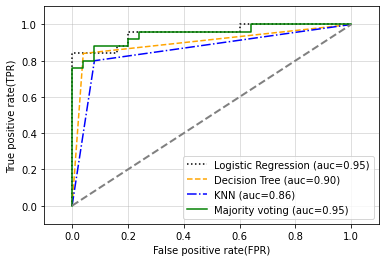

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc=%.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("False positive rate(FPR)")
plt.ylabel("True positive rate(TPR)")
plt.show()

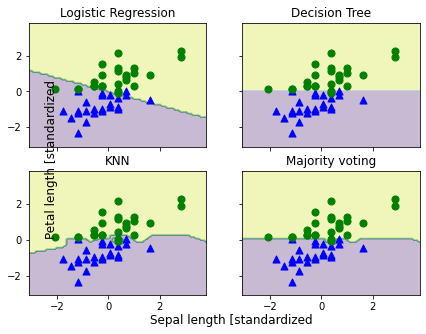

In [11]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(x_min, x_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue',marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='green',marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5, s='Sepal length [standardized', ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Petal length [standardized', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

In [12]:
mv_clf.get_params()


{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [22]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

for params, mean_score, scores in zip(grid.cv_results_['params'],
                                      grid.cv_results_['mean_test_score'],
                                      grid.cv_results_['std_test_score']):
    print("%0.3f+/-%0.2f %r" % (mean_score, scores.std() / 2, params))
print("best parameters: %s" % grid.best_params_)

0.983+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [21]:
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_decisiontreeclassifier__max_depth', 'param_pipeline-1__clf__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])